### Imports

In [3]:
import pandas as pd
import numpy as np
import os
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Data import

In [2]:
os.listdir('data')

['census_income_test.csv',
 'features.txt',
 'census_income_learn.csv',
 'census_income_metadata.txt']

In [4]:
# collecting the features from an extract of the metadata file
with open('data/features.txt', 'r') as f:
    l = f.readlines()
    features = {}
    for f in l:
        s = f[2:-1].split('\t')
        features[s[-1]] = s[0].lower().replace(' ', '_').replace('-','_')

# removing the unused features and fixing small naming issues
unused_features = ['AGI', 'FEDTAX', 'PEARNVAL', 'PTOTVAL', 'TAXINC']
for f in unused_features:
    del features[f]
    
features['ARACE'] = 'race'
features['DIVVAL'] = 'divdends_from_stocks'
features['VETQVA'] = 'fill_inc_questionnaire_for_veterans_admin'

# adding the missing variables
features['YEAR'] = 'year'
features['YTARGET'] = 'income class'

pprint.pprint(features)

{'AAGE': 'age',
 'ACLSWKR': 'class_of_worker',
 'ADTIND': 'industry_code',
 'ADTOCC': 'occupation_code',
 'AHGA': 'education',
 'AHRSPAY': 'wage_per_hour',
 'AHSCOL': 'enrolled_in_edu_inst_last_wk',
 'AMARITL': 'marital_status',
 'AMJIND': 'major_industry_code',
 'AMJOCC': 'major_occupation_code',
 'ARACE': 'race',
 'AREORGN': 'hispanic_origin',
 'ASEX': 'sex',
 'AUNMEM': 'member_of_a_labor_union',
 'AUNTYPE': 'reason_for_unemployment',
 'AWKSTAT': 'full_or_part_time_employment_stat',
 'CAPGAIN': 'capital_gains',
 'CAPLOSS': 'capital_losses',
 'DIVVAL': 'divdends_from_stocks',
 'FILESTAT': 'tax_filer_status',
 'GRINREG': 'region_of_previous_residence',
 'GRINST': 'state_of_previous_residence',
 'HHDFMX': 'detailed_household_and_family_stat',
 'HHDREL': 'detailed_household_summary_in_household',
 'MARSUPWT': 'instance_weight',
 'MIGMTR1': 'migration_code_change_in_msa',
 'MIGMTR3': 'migration_code_change_in_reg',
 'MIGMTR4': 'migration_code_move_within_reg',
 'MIGSAME': 'live_in_this_ho

Note : this method relies on the fact that the features in the dataset follow the same order than the ones listed in the metadata file. Thus, using a Python $\texttt{dict}$ to list them and enrich them with a description will not cause any trouble at the stage below:

In [5]:
test = pd.read_csv('data/census_income_test.csv', names=list(features))
train = pd.read_csv('data/census_income_learn.csv', names=list(features))

In [6]:
train.head()

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,YTARGET
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


The columns are correctly labeled now.

### Data visualization

In [7]:
train.describe(include='all')

,AAGE,ACLSWKR,ADTIND,ADTOCC,AHGA,AHRSPAY,AHSCOL,AMARITL,AMJIND,AMJOCC,...,PEFNTVTY,PEMNTVTY,PENATVTY,PRCITSHP,SEOTR,VETQVA,VETYN,WKSWORK,YEAR,YTARGET
count,199523.000000,199523,199523.000000,199523.000000,199523,199523.000000,199523,199523,199523,199523,...,199523,199523,199523,199523,199523.000000,199523,199523.000000,199523.000000,199523.000000,199523
unique,NaN,9,NaN,NaN,17,NaN,3,7,24,15,...,43,43,43,5,NaN,3,NaN,NaN,NaN,2
top,NaN,Not in universe,NaN,NaN,High school graduate,NaN,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,NaN,Not in universe,NaN,NaN,NaN,- 50000.
freq,NaN,100245,NaN,NaN,48407,NaN,186943,86485,100684,100684,...,159163,160479,176989,176992,NaN,197539,NaN,NaN,NaN,187141
mean,34.494199,NaN,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.175438,NaN,1.514833,23.174897,94.499672,NaN
std,22.310895,NaN,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.553694,NaN,0.851473,24.411488,0.500001,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,15.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,94.000000,NaN
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


#### Continuous variables

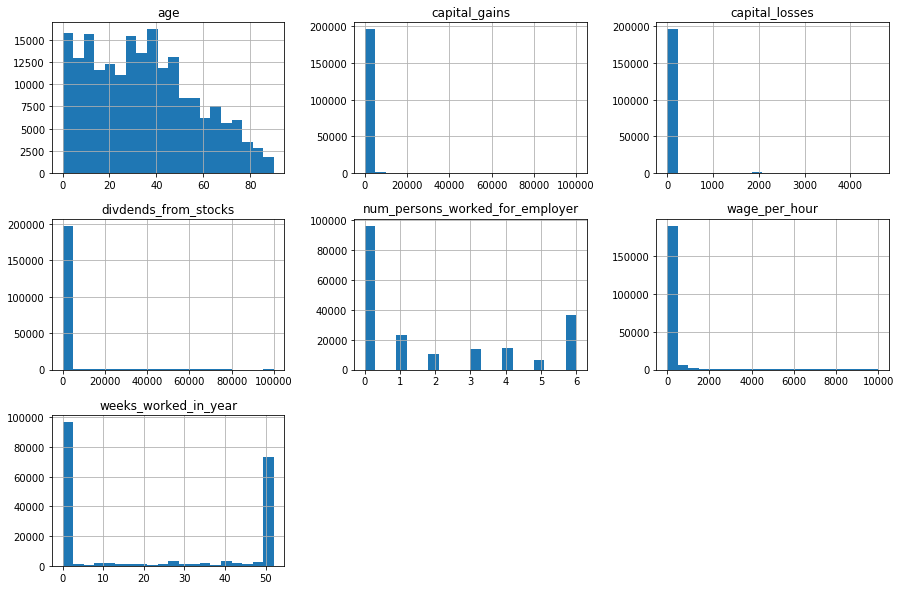

In [8]:
continuous_vars = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'NOEMP', 'WKSWORK']

train[continuous_vars]\
    .rename(columns={c: features[c] for c in continuous_vars})\
    .hist(figsize=(15,10), bins=20)
plt.show()

> The only "real" continuous variable is the age, the others seem more to be categorical.

> For instance, the capital gains/losses, dividends and hourly wage could be cast as a boolean modelling whether the value of this feature is equal to zero or not.

> About the weeks worked in year, the value could be sorted into three categories : zero (min value), max value (which should be 52) and "other" (all values strictly between min and max)

> Finally some of the "num_persons_worked_for_employer" could be merged, with resulting categories that could be "0", "1-2"; "3-6" (this split has to be tested).

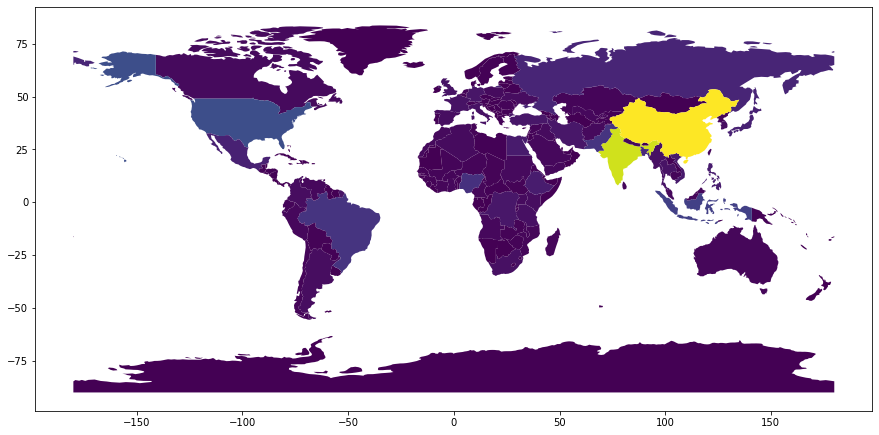

In [14]:
import geopandas
import descartes

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(column='pop_est', figsize=(15,30))

In [35]:
# Remember not to train the models on the weight feature